# Índice

- [Descripción del proyecto](#Descripción-del-proyecto)
- [Exploración de datos](#Exploración-de-datos)
- [Desarrollo de modelo](#Desarrollo-de-modelo)
- [Pruebas de modelo](#Pruebas-de-modelo)
- [Modelos sugeridos](#Modelos-sugeridos)
- [Conclusión](#Conclusión)

## Descripción del proyecto
La compañía móvil Megaline no está satisfecha al ver que muchos de sus clientes utilizan planes heredados. Quieren desarrollar un modelo que pueda analizar el comportamiento de los clientes y recomendar uno de los nuevos planes de Megaline: Smart o Ultra.

Tienes acceso a los datos de comportamiento de los suscriptores que ya se han cambiado a los planes nuevos . Para esta tarea de clasificación debes crear un **modelo que escoja el plan correcto**. Como ya hiciste el paso de procesar los datos, puedes lanzarte directo a crear el modelo.

Desarrolla un modelo con la mayor *exactitud* posible. En este proyecto, el umbral de *exactitud* es 0.75. Usa el dataset para comprobar la *exactitud*.



### Descripción de datos

Cada observación en el dataset contiene información del comportamiento mensual sobre un usuario. La información dada es la siguiente:

- `сalls` — número de llamadas,
- `minutes` — duración total de la llamada en minutos,
- `messages` — número de mensajes de texto,
- `mb_used` — Tráfico de Internet utilizado en MB,
- `is_ultra` — plan para el mes actual (Ultra - 1, Smart - 0).


Se inicia importando las librerias necesarias

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

## Exploración de datos

In [32]:
data = pd.read_csv('datasets/users_behavior.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Utilicé la función read_csv de pandas para cargar un archivo CSV llamado 'users_behavior.csv'.
 Ejecuté el método info() en data para obtener un resumen conciso del DataFrame.

In [33]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Con el método head() aplicado al DataFrame data, estoy obteniendo una vista previa de las primeras cinco filas del conjunto de datos.

In [34]:

data.isnull().sum()



calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [35]:
duplicados = data[data.duplicated()]
print('Número de registros duplicados:', duplicados.shape[0])

if not duplicados.empty:
    print(duplicados.head()) 

columnas_a_revisar = ['calls', 'minutes','messages','mb_used','is_ultra']
duplicados_en_columnas = data[data.duplicated(subset=columnas_a_revisar)]
print('Número de registros duplicados basados en las columnas especificadas:', duplicados_en_columnas.shape[0])


Número de registros duplicados: 0
Número de registros duplicados basados en las columnas especificadas: 0


Se observa que no existen duplicados en el data frame a traves del codigo anterior.

 Utilizando el método isnull() en el DataFrame data, determino qué valores son nulos (o NaN) en todo el conjunto de datos. Al encadenar con el método sum(), sumo la cantidad de valores nulos en cada columna.

In [36]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Con el método describe() aplicado al DataFrame data, estoy obteniendo un resumen que incluye medidas estadísticas centrales y de dispersión

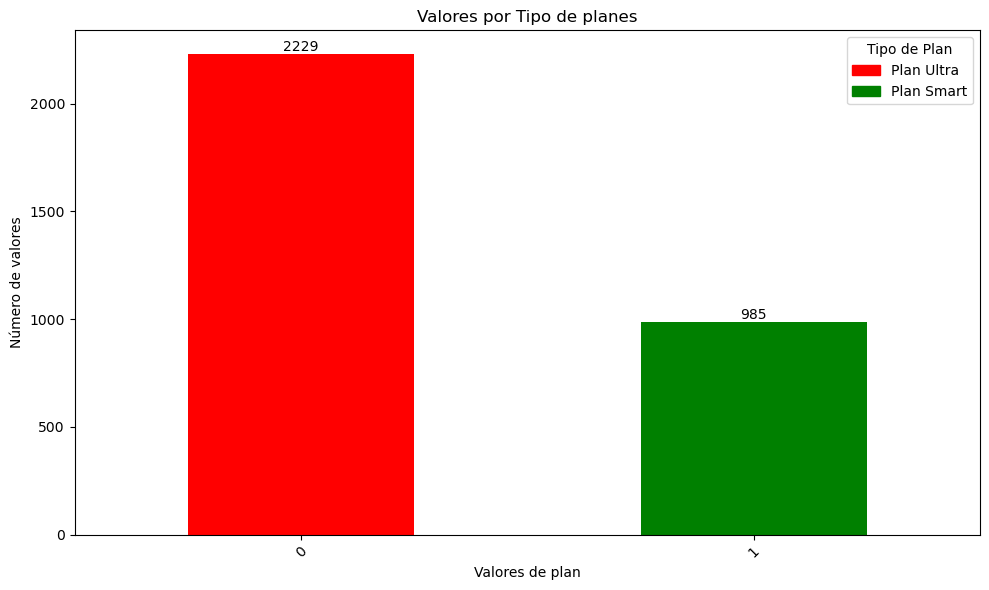

In [37]:
valores_objetivo = data['is_ultra'].value_counts()
valores_objetivo

colores = ['red', 'green']  
etiquetas = ['Plan Ultra', 'Plan Smart']  
ax = valores_objetivo.plot(kind='bar', figsize=(10,6), color=colores)
plt.title('Valores por Tipo de planes')
plt.xlabel('Valores de plan')
plt.ylabel('Número de valores')
plt.xticks(rotation=45)

for bar in ax.containers:
    ax.bar_label(bar)

handles = [plt.Rectangle((0,0),1,1, color=colores[i]) for i in range(len(etiquetas))]
plt.legend(handles, etiquetas, title="Tipo de Plan")
plt.tight_layout()
plt.show()

De acuerdo con los datos obtenidos de la columna objetivo se determina que la proporcion de estos tiene una diferencia notable, entre los que destaca el plan Ultra frente al plan Smart.

## Desarrollo de modelo

In [39]:

features = data.drop(['is_ultra'], axis=1)
target = data['is_ultra'] 


Estoy preparando mis datos dividiéndolos en características (features) y objetivo (target).

In [41]:
#features_train, features_valid, target_train, target_valid = train_test_split(
#    features, target, test_size=0.25, random_state=12345) 


# Primer paso: Dividir datos entre entrenamiento y un conjunto temporal (usando, por ejemplo, 80% para entrenamiento y 20% para el conjunto temporal)
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.2, random_state=12345)

# Segundo paso: Dividir el conjunto temporal entre validación y prueba (por ejemplo, 50% para validación y 50% para prueba del conjunto temporal)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=12345)



He dividido mis datos en dos conjuntos: uno para entrenar el modelo y otro para validar su rendimiento, asegurándome de que el proceso sea reproducible al establecer un estado aleatorio específico.

In [45]:
param_grid = {
    'n_estimators': [25,50,75,100],
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'min_samples_split': [3, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1)
grid_search.fit(features_train, target_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"El mejor modelo contiene max_depth: {best_model.max_depth},min_samples_split: {best_model.min_samples_split},n_estimators: {best_model.n_estimators}")
print(best_model)

El mejor modelo contiene max_depth: 10,min_samples_split: 10,n_estimators: 25
RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=25)


Estoy utilizando GridSearchCV para encontrar la mejor combinación de parámetros para un RandomForestClassifier basado en mi conjunto de entrenamiento, y luego imprimo esta mejor combinación y el modelo correspondiente.

In [48]:
test_prediction = best_model.predict(features_valid)
accuracy = accuracy_score(target_valid,test_prediction)
print(f'Accuaracy on test set : {accuracy}')

if accuracy > 0.75:
    print("El modelo supera el umbral de exactitud requerido.")
else:
    print("El modelo no alcanza el umbral de exactitud requerido. Considera ajustar el modelo o los hiperparámetros.")


Accuaracy on test set : 0.7975077881619937
El modelo supera el umbral de exactitud requerido.


Evaluo el rendimiento del mejor modelo en el conjunto de validación, calculando su exactitud y verificando si cumple con el criterio de exactitud establecido (0.75 en este caso).

## Pruebas de modelo 

In [49]:

print(classification_report(target_valid, test_prediction))


              precision    recall  f1-score   support

           0       0.80      0.93      0.86       218
           1       0.78      0.51      0.62       103

    accuracy                           0.80       321
   macro avg       0.79      0.72      0.74       321
weighted avg       0.80      0.80      0.78       321



Generé un informe detallado de cómo se desempeña el modelo en términos de precisión, recall y f1-score para cada clase en el conjunto de validación. Es una herramienta valiosa para comprender en profundidad cómo el modelo está clasificando cada categoría.

De esta forma el modelo parece tener un rendimiento bastante bueno en la predicción de la clase 0, pero no tan bien en la clase 1, especialmente en términos de recall (solo captura el 51% de las instancias verdaderas de la clase 1).

La exactitud global del modelo es del 80%, lo que supera el umbral del 75%.

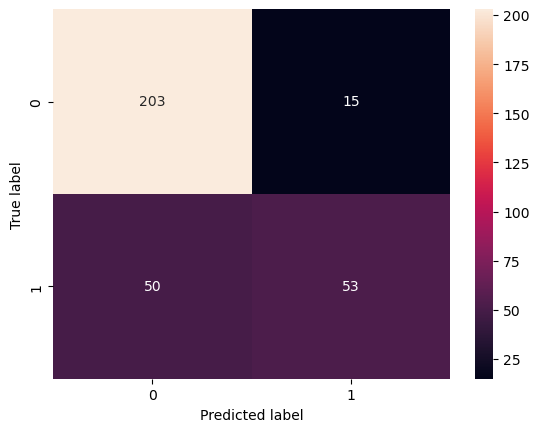

In [50]:

cm = confusion_matrix(target_valid, test_prediction)
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


 Generé una representación visual de la matriz de confusión, que proporciona información sobre las verdaderas positivas, verdaderas negativas, falsas positivas y falsas negativas que el modelo predijo en el conjunto de validación.
 Los valores presentados son:

203 (esquina superior izquierda): Verdaderos Negativos (TN). El modelo predijo correctamente que 527 instancias eran de la clase 0.

15 (esquina superior derecha): Falsos Positivos (FP). El modelo predijo incorrectamente que 36 instancias eran de la clase 1 cuando en realidad eran de la clase 0.

50 (esquina inferior izquierda): Falsos Negativos (FN). El modelo predijo incorrectamente que 116 instancias eran de la clase 0 cuando en realidad eran de la clase 1.

53 (esquina inferior derecha): Verdaderos Positivos (TP). El modelo predijo correctamente que 125 instancias eran de la clase 1.

## Modelos sugeridos

1. Regresión Logística:

In [51]:

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(features_train, target_train)
predictions = logreg.predict(features_valid)
print("Accuracy Regresión Logística:", accuracy_score(target_valid, predictions))


Accuracy Regresión Logística: 0.7663551401869159


Pruebo un modelo de regresión logística en el conjunto de validación para determinar su desempeño, sin embargo este suele ser menor que el anteriormente planteado.

4. Gradient Boosting:

In [52]:

gboost = GradientBoostingClassifier(random_state=42)
gboost.fit(features_train, target_train)
predictions = gboost.predict(features_valid)
print("Accuracy Gradient Boosting:", accuracy_score(target_valid, predictions))


Accuracy Gradient Boosting: 0.794392523364486


Pruebo un modelo Gradiet Boosting en el conjunto de validación, despues muesto la exactitud del modelo para determinar su capacidad de clasificación, siendo el resultado menor que el modelo planteado originalmente, sin embargo podria decirse que estan a la par.

In [53]:

svc = SVC(random_state=42)
svc.fit(features_train, target_train)
predictions = svc.predict(features_valid)
print("Accuracy SVM:", accuracy_score(target_valid, predictions))


Accuracy SVM: 0.7507788161993769


Entreno un modelo de Máquina de Soporte Vectorail en el conjunto de validación para presentar su exactitud siendo esta menor que la presentada por el modelo planteado originalmente.

## Conclusión


El objetivo principal era desarrollar un modelo de clasificación que ayude a Megaline a recomendar a sus clientes uno de los dos planes: Smart o Ultra. Se estableció un umbral de exactitud de 0.75 como punto de referencia para el éxito del modelo.

Modelo de Bosques Aleatorios (Random Forest):

Se llevó a cabo una optimización de hiperparámetros para el modelo de Random Forest utilizando GridSearchCV. La configuración de hiperparámetros que se exploró incluyó diferentes valores para 'n_estimators', 'max_depth' y 'min_samples_split'.
El modelo de Random Forest optimizado tuvo una profundidad máxima (max_depth) de 10, un min_samples_split de 10 y utilizó 25 estimadores (n_estimators).
Al evaluar este modelo en el conjunto de validación, se logró una exactitud de aproximadamente 0.79, superando el umbral establecido de 0.75.

Evaluación detallada del modelo:

El informe de clasificación mostró que el modelo tiene una precisión de 0.80 para la clase 0 y 0.78 para la clase 1. El recall para la clase 0 fue particularmente alto, alrededor de 0.93, mientras que para la clase 1 fue de 0.51.
La matriz de confusión visualizada sugiere que el modelo tuvo un desempeño bastante bueno al clasificar la clase 0, pero tuvo un número mayor de falsos negativos al clasificar la clase 1. Específicamente, el modelo predijo correctamente 203 instancias de la clase 0 y 53 de la clase 1. Sin embargo, clasificó erróneamente 15 instancias como clase 0 cuando en realidad eran de la clase 1 y 50 instancias como clase 1 cuando en realidad eran de la clase 0.

Conclusión Final:
El modelo de Random Forest optimizado logró un rendimiento satisfactorio, superando el umbral de exactitud establecido. Sin embargo, hay margen de mejora en la clasificación de la clase 1, ya que el modelo mostró un número significativo de falsos negativos. En futuras iteraciones, se podría considerar la posibilidad de explorar técnicas de balanceo de clases o ajustar aún más los hiperparámetros para mejorar la sensibilidad del modelo hacia la clase minoritaria. También se podría explorar la inclusión de más características, así como probar otros algoritmos de clasificación avanzados.